In [ ]:
!pip install kora -q
from kora import drive
drive.link_nbs()

In [ ]:
import utils

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install efficientnet

In [63]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import efficientnet.keras as efn
from keras.applications.efficientnet import EfficientNetB0
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization

In [ ]:
IMG_SIZE = (224,224)
EPOCHS = 30
NUM_CLASSES = 4

In [9]:
""" Load TVHI dataset """
#Load the dataset which has already been preprocessed, set needDirectories to False if SF_train, SF_test, and SF_validation dirs already exist
train_ds, test_ds, val_ds, train_labels, test_labels, validation_labels, class_names = utils.loadTVHI(img_size = IMG_SIZE, needDirectories=False)

#Path to pre-trained model
SF_weights = "/content/drive/MyDrive/model_weights.h5"


--2022-04-13 15:16:18--  http://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz [following]
--2022-04-13 15:16:18--  https://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163535078 (156M) [application/x-gzip]
Saving to: ‘tv_human_interactions_videos.tar.gz.3’

tv_human_interactio 100%[===================>] 155.96M  34.2MB/s    in 5.2s    

2022-04-13 15:16:23 (30.1 MB/s) - ‘tv_human_interactions_videos.tar.gz.3’ saved [163535078/163535078]

--2022-04-13 15:16:23--  http://www.robots.ox.ac.uk/~alonso/data/re

In [10]:
""" One-hot encoding """

def onehot_encoding(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

#Apply one hot encoding to the different datasets
train_ds = train_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(onehot_encoding)


In [ ]:
#https://proceedings.neurips.cc/paper/2019/file/fd2c5e4680d9a01dba3aada5ece22270-Paper.pdf    - reference for using batch normalisation

In [86]:
SF_weights = "/content/drive/MyDrive/model_weights"

In [87]:
""" Build transfer learning model """

def build_tfl_model(num_classes):
    inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    img_augmentation = utils.dataAugmentation()
    x = img_augmentation(inputs)
    tfl_model = EfficientNetB0(include_top=False, input_tensor=x, weights=SF_weights)

    # Freeze pretrained weights so no more training will happen 
    tfl_model.trainable = False

    # Add new top layers that will be trained
    x = GlobalAveragePooling2D(name="avg_pool")(tfl_model.output)
    x = BatchNormalization()(x)

    #Set dropout rate to 0.2 to adjust for overfitting as transfer learning is prone to overfitting
    dropout_rate = 0.2
    x = Dropout(dropout_rate, name="top_dropout")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile the model with Adam optimiser, learning rate set to rather large to begin with 
    tfl_model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    #tfl_model.load_weights("/content/drive/MyDrive/model_weights.h5")
    tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    tfl_model.compile(
        optimizer=tf_optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return tfl_model


In [88]:
""" Train the model """
#Build the model
model = build_tfl_model(num_classes=NUM_CLASSES)

#Fit the model 
history = model.fit(train_ds, epochs=50, validation_data=val_ds, verbose=2)

#Save weights and model as we need these for transfer learning 
model.save_weights("TFL_weights.h5")
model.save("TFL_model")


ValueError: ignored

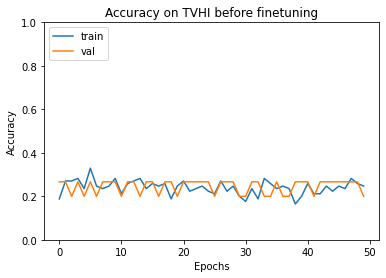

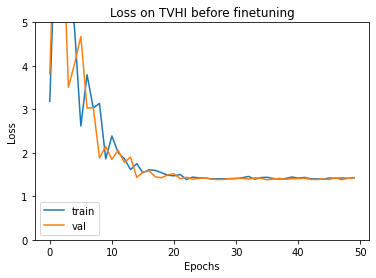

In [82]:
#Plot loss and accuracy before finetuning
utils.plotAccuracy("Accuracy on TVHI before finetuning", history.history['accuracy'], history.history['val_accuracy'])                   
utils.plotLoss("Loss on TVHI before finetuning", history.history['loss'], history.history['val_loss'])